In [1]:
library(cowplot)
library(dplyr)
library(stringr)
library(readr)
library(tidyr)
library(lfe)
library(scales)
library(repr)
library(stargazer)
library(doMC)
library(sjPlot)
registerDoMC(12)


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘scales’


The following object is masked from ‘package:readr’:

    col_factor



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 


Loading required package: foreach

Loading required package: iterators

Loading 

In [2]:
panel <- readRDS('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/data_v2.RData')
load('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/conley_selector_matrix.Rdata')
load('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/social_adj_matrix.RData')
load('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/geo_adjacency_matrix.Rdata')
source('../utils/residualizer+genAlters.R')
source("../utils/labels_and_colors.r")
source('../utils/adjacency_and_cluster_robust_inference.R')
source('../utils/geo_utils.r')

Loaded glmnet 3.0-2



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘lmtest’


The following object is masked from ‘package:lfe’:

    waldtest




In [3]:
model_location <- '/nfs/sloanlab004/projects/covid_mobility_proj/models/did_placebo_state/'
model_prefix <- 'DiD_state_geoSocial_'

In [4]:
head(panel)

ds,county_fips,sg_nhd,ash_nhd,state_abbv,stay_home,PRCP,TMAX,fb_btvrc,fb_rnstu,⋯,iv368,iv369,iv370,iv371,iv372,iv373,iv374,iv375,iv376,iv377
<date>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-03-01,1001,0.7637755,0.7041312,AL,0,0.00000000,20.26667,0.11245388,0.8800191,⋯,0.005357271,0.006663710,0.003511309,0.004241189,0.004072092,0.002667733,0.007564764,0.0012265722,1.372792e-03,0.0022149108
2020-03-01,1003,0.7363590,0.6821986,AL,0,0.01304348,20.57500,0.10008760,0.8748285,⋯,0.006137997,0.006348736,0.004151409,0.002834256,0.002809559,0.001936217,0.006396609,0.0005820805,8.375583e-04,0.0012945267
2020-03-01,1005,0.7258938,0.6737506,AL,0,0.00000000,17.20000,0.16629393,0.9076493,⋯,0.009109887,0.006426609,0.005651953,0.007230479,0.005569759,0.004599765,0.015908641,0.0039989973,4.200572e-03,0.0081765988
2020-03-01,1007,0.7555653,0.6975934,AL,0,0.00000000,20.60000,0.11779337,0.9035088,⋯,0.004777497,0.005818908,0.004105634,0.003127532,0.002442699,0.001934998,0.006958150,-0.0001016781,5.247706e-05,0.0001270144
2020-03-01,1009,0.7719222,0.7105927,AL,0,0.00000000,18.90000,0.08822023,0.8926064,⋯,0.004944538,0.004278320,0.002546250,0.002235429,0.001753761,0.001393184,0.004096344,-0.0001758338,-2.536857e-05,-0.0002467153
2020-03-01,1011,0.6967632,0.6500129,AL,0,0.00000000,19.13333,0.16487885,0.9151515,⋯,0.005793979,0.005664000,0.003137927,0.003334738,0.003452031,0.002706258,0.007705054,0.0012745797,1.470142e-03,0.0029409972


In [5]:
DV = c('ash_rnstu', 'ash_nhd', 'fb_btvrc', 'log_mcbgv')

### compute f stat on the observed model

In [133]:
formula_1 <- ash_rnstu.r ~ 0 + stay_home.r + alter_sh.r + geo_alter_sh.r + ban_gmr.r + alter_bgmr.r + geo_alter_bgmr.r | county_fips + ds | 0 | state_abbv
wald_formula <- ~ alter_sh.r + geo_alter_sh.r
wald_formula_gmr <- ~ alter_bgmr.r + geo_alter_bgmr.r

In [156]:
fm <- felm(
        formula_1,
        data = panel,
        weights = panel$n
    )
f_obs1 = lfe::waldtest(fm, wald_formula)['F']
f_obs1_gmr = lfe::waldtest(fm, wald_formula_gmr)['F']
f_obs1
f_obs1_gmr

f_obs1_df <- data.frame(f_obs = c(f_obs1, f_obs1_gmr),
                        policy = c('Shelter-in-place', 
                                'Close gyms, movie theaters, and restaurants'))

F 
14.58551

F 
0.09963695

In [135]:
formula_2 <- ash_nhd.r ~ 0 + stay_home.r + alter_sh.r + geo_alter_sh.r + ban_gmr.r + alter_bgmr.r + geo_alter_bgmr.r | county_fips + ds | 0 | state_abbv

In [155]:
fm <- felm(
        formula_2,
        data = panel,
        weights = panel$n
    )
f_obs2 = lfe::waldtest(fm, wald_formula)['F']
f_obs2_gmr = lfe::waldtest(fm, wald_formula_gmr)['F']
f_obs2
f_obs2_gmr

f_obs2_df <- data.frame(f_obs = c(f_obs2, f_obs2_gmr),
                        policy = c('Shelter-in-place', 
                                'Close gyms, movie theaters, and restaurants'))

F 
15.37948

F 
0.156498

In [10]:
formula_3 <- fb_btvrc.r ~ 0 + stay_home.r + alter_sh.r + geo_alter_sh.r + ban_gmr.r + alter_bgmr.r + geo_alter_bgmr.r | county_fips + ds | 0 | state_abbv

In [154]:
fm <- felm(
        formula_3,
        data = panel,
        weights = panel$n
    )
f_obs3 = lfe::waldtest(fm, wald_formula)['F']
f_obs3_gmr = lfe::waldtest(fm, wald_formula_gmr)['F']
f_obs3
f_obs3_gmr

f_obs3_df <- data.frame(f_obs = c(f_obs3, f_obs3_gmr),
                        policy = c('Shelter-in-place', 
                                'Close gyms, movie theaters, and restaurants'))

F 
41.01215

F 
10.32356

In [12]:
formula_4 <- log_mcbgv.r ~ 0 + stay_home.r + alter_sh.r + geo_alter_sh.r + ban_gmr.r + alter_bgmr.r + geo_alter_bgmr.r | county_fips + ds | 0 | state_abbv

In [146]:
fm <- felm(
        formula_4,
        data = panel,
        weights = panel$n
    )
f_obs4 = lfe::waldtest(fm, wald_formula)['F']
f_obs4_gmr = lfe::waldtest(fm, wald_formula_gmr)['F']
f_obs4
f_obs4_gmr

f_obs4_df <- data.frame(f_obs = c(f_obs4, f_obs4_gmr),
                        policy = c('Shelter-in-place', 
                                'Close gyms, movie theaters, and restaurants'))

F 
14.40295

F 
0.8609854

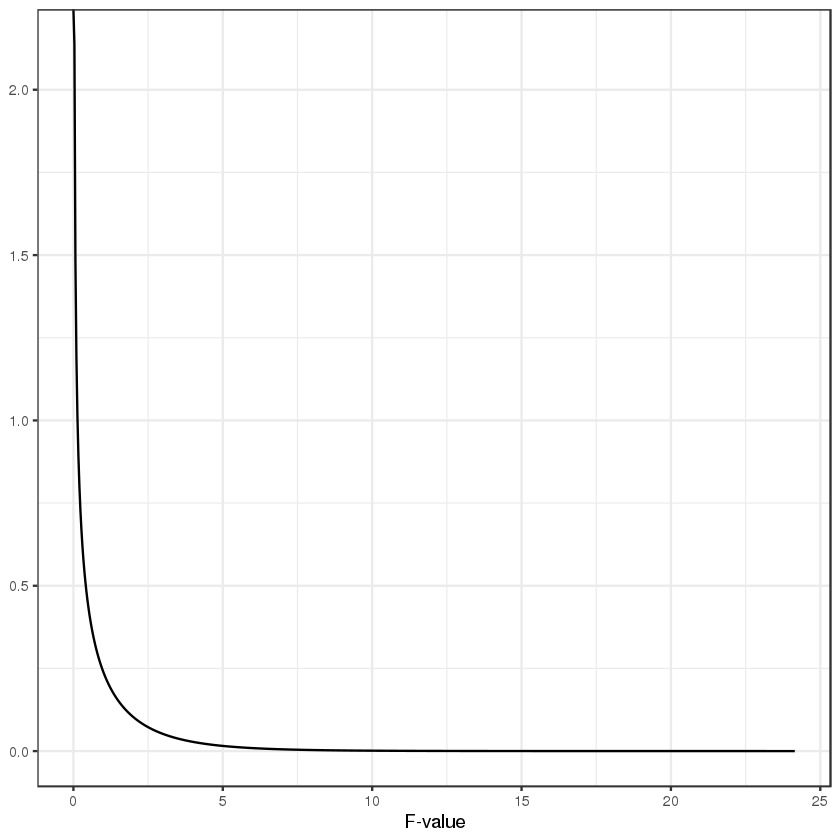

In [89]:
dof1 <- lfe::waldtest(fm, wald_formula)['df1']
dof2 <- lfe::waldtest(fm, wald_formula)['df2']
theoretical_f <- dist_f(deg.f1 = dof1,
                        deg.f2 = dof2)$data
theoretical_f %>% 
  mutate(y = 1000*y) -> theoretical_f

### compute f stat for placebo draws and show p-value and distribution 

In [ ]:
placebo = list.files(model_location)

### ash_rnstu

In [14]:
outcome = DV[1]
files = str_subset(placebo,paste0(model_prefix, outcome))

In [15]:
head(files)

[1] "DiD_state_geoSocial_ash_rnstu_0001.RDS"
[2] "DiD_state_geoSocial_ash_rnstu_0002.RDS"
[3] "DiD_state_geoSocial_ash_rnstu_0003.RDS"
[4] "DiD_state_geoSocial_ash_rnstu_0004.RDS"
[5] "DiD_state_geoSocial_ash_rnstu_0005.RDS"
[6] "DiD_state_geoSocial_ash_rnstu_0006.RDS"

In [142]:
foreach (i = 1:1000, .combine='rbind') %dopar% {
    
    fm = readRDS(paste0(model_location,files[i]))
    
    df <- data.frame(f = c(unname(lfe::waldtest(fm, wald_formula)['F']),
                           unname(lfe::waldtest(fm, wald_formula_gmr)['F'])),
                     policy = c('Shelter-in-place', 
                                'Close gyms, movie theaters, and restaurants')
                    )
    
} -> f1

In [229]:
f1 %>% 
  ggplot(., aes(x = f)) + geom_histogram(binwidth = 1, center = 0.5) + 
    geom_vline(data=f_obs1_df, aes(xintercept = f_obs), color = "red") + facet_wrap(~str_wrap(policy, 20)) +
    theme_bw() +
    xlab("F-statistic") + ylab('Count') + #ylim(c(0,1000)) + 
    #geom_line(aes(x=x, y=y), data=theoretical_f)+ xlim(0, f_obs1+1) + 
    theme(axis.text.x = element_text(hjust = 1, size=13),
        axis.text.y = element_text(size=13),
        axis.title = element_text(size=18),
        strip.text.y = element_text(size=16),
        panel.background = element_blank(),
        axis.line = element_line(colour = "black"),
        strip.text.x.top = element_text(size=16)) -> test1

[1] 0

[1] 0.763

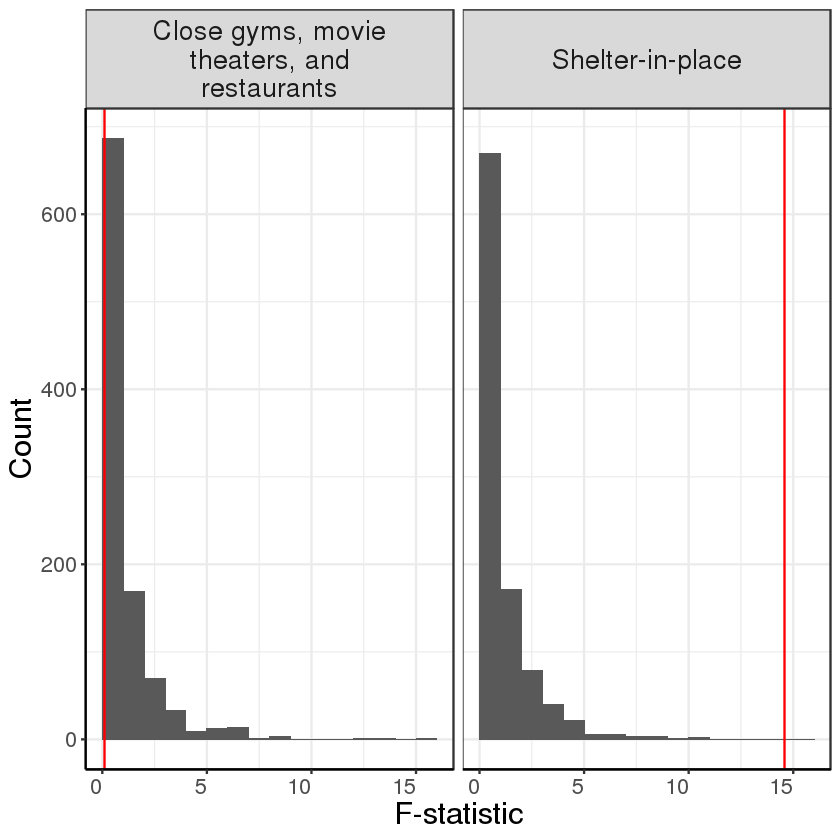

In [230]:
mean(filter(f1, policy=='Shelter-in-place')$f > f_obs1)
mean(filter(f1, policy=='Close gyms, movie theaters, and restaurants')$f > f_obs1_gmr)
test1

In [231]:
# Write plot to output
ggsave(
  paste0("../output/did_ri_rnstu.pdf"),
  plot = test1,
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 7,
  height = 5,
  units = c("in"),
  dpi = 200,
  limitsize = FALSE,
  useDingbats=FALSE
)

### ash_nhd

In [166]:
outcome = DV[2]
files = str_subset(placebo, paste0(model_prefix, outcome))

In [167]:
head(files)

[1] "DiD_state_geoSocial_ash_nhd_0001.RDS"
[2] "DiD_state_geoSocial_ash_nhd_0002.RDS"
[3] "DiD_state_geoSocial_ash_nhd_0003.RDS"
[4] "DiD_state_geoSocial_ash_nhd_0004.RDS"
[5] "DiD_state_geoSocial_ash_nhd_0005.RDS"
[6] "DiD_state_geoSocial_ash_nhd_0006.RDS"

In [172]:
foreach (i = 1:1000, .combine='rbind') %dopar% {
    
    fm = readRDS(paste0(model_location,files[i]))
    
    df <- data.frame(f = c(unname(lfe::waldtest(fm, wald_formula)['F']),
                           unname(lfe::waldtest(fm, wald_formula_gmr)['F'])),
                     policy = c('Shelter-in-place', 
                                'Close gyms, movie theaters, and restaurants')
                    )
    
} -> f2

In [232]:
f2 %>% 
  ggplot(., aes(x = f)) + geom_histogram(binwidth = 1, center = 0.5) + 
    geom_vline(data=f_obs2_df, aes(xintercept = f_obs), color = "red") + facet_wrap(~str_wrap(policy, 20)) +
    theme_bw() +
    xlab("F-statistic") + ylab('Count') + #ylim(c(0,1000)) + 
    #geom_line(aes(x=x, y=y), data=theoretical_f)+ xlim(0, f_obs2+1) + 
    theme(axis.text.x = element_text(hjust = 1, size=13),
        axis.text.y = element_text(size=13),
        axis.title = element_text(size=18),
        strip.text.y = element_text(size=16),
        panel.background = element_blank(),
        axis.line = element_line(colour = "black"),
        strip.text.x.top = element_text(size=16)) -> test2

[1] 0

[1] 0.706

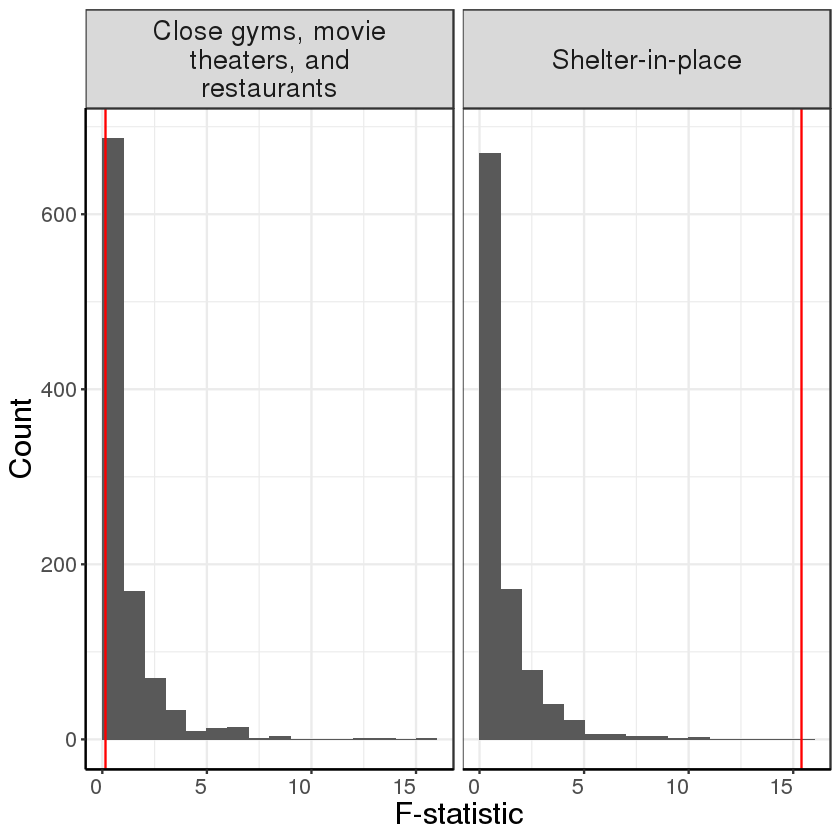

In [233]:
mean(filter(f2, policy=='Shelter-in-place')$f > f_obs2)
mean(filter(f2, policy=='Close gyms, movie theaters, and restaurants')$f > f_obs2_gmr)
test2

In [234]:
# Write plot to output
ggsave(
  paste0("../output/did_ri_nhd.pdf"),
  plot = test2,
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 7,
  height = 5,
  units = c("in"),
  dpi = 200,
  limitsize = FALSE,
  useDingbats=FALSE
)

### fb_btvrc

In [176]:
outcome = DV[3]
files = str_subset(placebo,paste0(model_prefix, outcome))

In [177]:
head(files)

[1] "DiD_state_geoSocial_fb_btvrc_0001.RDS"
[2] "DiD_state_geoSocial_fb_btvrc_0002.RDS"
[3] "DiD_state_geoSocial_fb_btvrc_0003.RDS"
[4] "DiD_state_geoSocial_fb_btvrc_0004.RDS"
[5] "DiD_state_geoSocial_fb_btvrc_0005.RDS"
[6] "DiD_state_geoSocial_fb_btvrc_0006.RDS"

In [178]:
foreach (i = 1:1000, .combine='rbind') %dopar% {
    
    fm = readRDS(paste0(model_location,files[i]))
    
    df <- data.frame(f = c(unname(lfe::waldtest(fm, wald_formula)['F']),
                           unname(lfe::waldtest(fm, wald_formula_gmr)['F'])),
                     policy = c('Shelter-in-place', 
                                'Close gyms, movie theaters, and restaurants')
                    )
    
} -> f3

In [235]:
f3 %>% 
  ggplot(., aes(x = f)) + geom_histogram(binwidth = 1, center = 0.5) + 
    geom_vline(data=f_obs3_df, aes(xintercept = f_obs), color = "red") + facet_wrap(~str_wrap(policy, 20)) +
    theme_bw() +
    xlab("F-statistic") + ylab('Count') + #ylim(c(0,1000)) + 
    #geom_line(aes(x=x, y=y), data=theoretical_f)+ xlim(0, f_obs3+1) + 
    theme(axis.text.x = element_text(hjust = 1, size=13),
        axis.text.y = element_text(size=13),
        axis.title = element_text(size=18),
        strip.text.y = element_text(size=16),
        panel.background = element_blank(),
        axis.line = element_line(colour = "black"),
        strip.text.x.top = element_text(size=16)
       ) -> test3

[1] 0

[1] 0

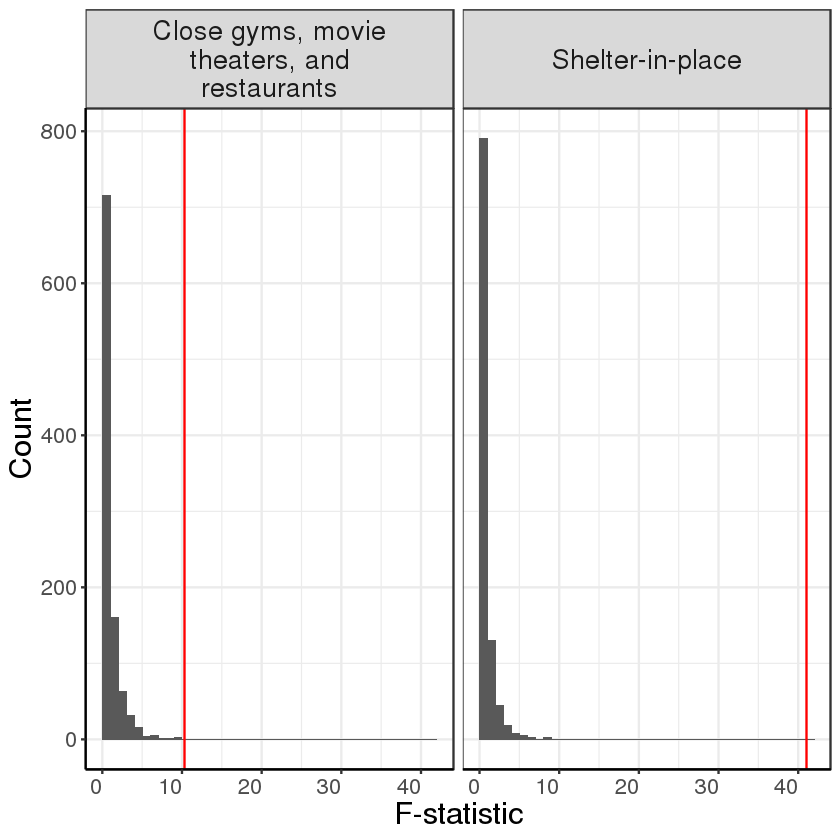

In [236]:
mean(filter(f3, policy=='Shelter-in-place')$f > f_obs3)
mean(filter(f3, policy=='Close gyms, movie theaters, and restaurants')$f > f_obs3_gmr)
test3

In [237]:
# Write plot to output
ggsave(
  paste0("../output/did_ri_btvrc.pdf"),
  plot = test3,
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 7,
  height = 5,
  units = c("in"),
  dpi = 200,
  limitsize = FALSE,
  useDingbats=FALSE
)

### log_mcbgv

In [185]:
outcome = DV[4]
files = str_subset(placebo,paste0(model_prefix, outcome))

In [186]:
head(files)

[1] "DiD_state_geoSocial_log_mcbgv_0001.RDS"
[2] "DiD_state_geoSocial_log_mcbgv_0002.RDS"
[3] "DiD_state_geoSocial_log_mcbgv_0003.RDS"
[4] "DiD_state_geoSocial_log_mcbgv_0004.RDS"
[5] "DiD_state_geoSocial_log_mcbgv_0005.RDS"
[6] "DiD_state_geoSocial_log_mcbgv_0006.RDS"

In [187]:
foreach (i = 1:1000, .combine='rbind') %dopar% {
    
    fm = readRDS(paste0(model_location,files[i]))
    
    df <- data.frame(f = c(unname(lfe::waldtest(fm, wald_formula)['F']),
                           unname(lfe::waldtest(fm, wald_formula_gmr)['F'])),
                     policy = c('Shelter-in-place', 
                                'Close gyms, movie theaters, and restaurants')
                    )
    
    
} -> f4

In [243]:
f4 %>% 
  ggplot(., aes(x = f)) + geom_histogram(binwidth = 1, center = 0.5) + 
    geom_vline(data=f_obs4_df, aes(xintercept = f_obs), color = "red") + facet_wrap(~str_wrap(policy, 20)) +
    theme_bw() +
    xlab("F-statistic") + ylab('Count') + #ylim(c(0,1000)) + 
    #geom_line(aes(x=x, y=y), data=theoretical_f)+ xlim(0, f_obs4+1) + 
    theme(axis.text.x = element_text(hjust = 1, size=13),
        axis.text.y = element_text(size=13),
        axis.title = element_text(size=18),
        strip.text.y = element_text(size=16),
        panel.background = element_blank(),
        axis.line = element_line(colour = "black"),
        strip.text.x.top = element_text(size=16)) -> test4

[1] 0

[1] 0.346

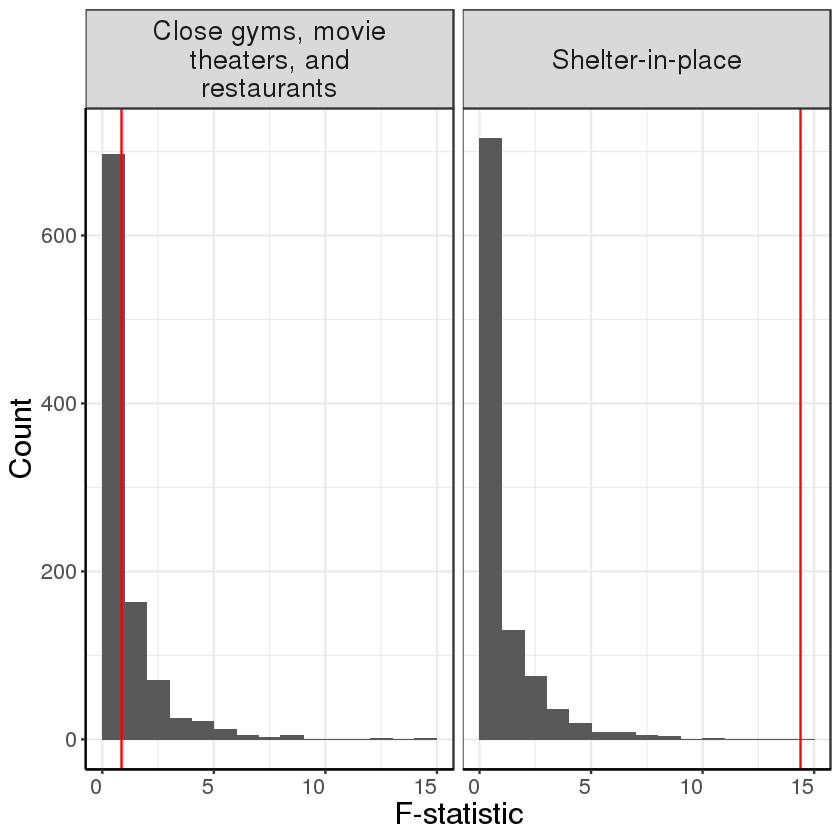

In [244]:
mean(filter(f4, policy=='Shelter-in-place')$f > f_obs4)
mean(filter(f4, policy=='Close gyms, movie theaters, and restaurants')$f > f_obs4_gmr)
test4

In [245]:
# Write plot to output
ggsave(
  paste0("../output/did_ri_mcbgv.pdf"),
  plot = test4,
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 7,
  height = 5,
  units = c("in"),
  dpi = 200,
  limitsize = FALSE,
  useDingbats=FALSE
)

doFRI <- function(outcome) {
    
    # compute the observed f stat
    
    formula <- paste0(outcome,
                      '.r',
                      '~ 0 + stay_home.r + alter_sh.r + geo_alter_sh.r + ban_gmr.r + alter_bgmr.r + geo_alter_bgmr.r | county_fips + ds | 0 | state_abbv')
    wald_formula <- ~ alter_sh.r + geo_alter_sh.r
    
    
    fm <- felm(
        formula,
        data = panel,
        weights = panel$n
    )
    
    f_obs = lfe::waldtest(fm, wald_formula)['F']
    
    
    # compute f stat for all placebo draws
    
    placebo = list.files('/nfs/sloanlab004/projects/covid_mobility_proj/models/did_placebo/')
    files = str_subset(placebo,paste0('DiD_geoSocial_',outcome))
    
    foreach (i = 1:1000, .combine=c) %dopar% {
    
    fm = readRDS(paste0('/nfs/sloanlab004/projects/covid_mobility_proj/models/did_placebo/',files[i]))
    
    unname(lfe::waldtest(fm, wald_formula)['F'])
    
    
} -> f
    
    list(f_obs,f)
}